In [1]:
%%time
import os
import gc
import time
import pandas as pd
from langchain.document_loaders import DirectoryLoader,PyMuPDFLoader,PyPDFLoader
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain import PromptTemplate,LLMChain
from langchain.llms import HuggingFacePipeline
from langchain_groq.chat_models import ChatGroq
from IPython.display import clear_output
clear_output()

CPU times: total: 1.23 s
Wall time: 1.5 s


In [2]:
class CFG:
    ### debug
    DEBUG = True
    MAX_CHUNKS = 50 if DEBUG else 1_000_000
    
    ### synthetic data settings
    MIN_CHUNK_SIZE = 200
    PAGES_TO_SKIP = 5
    
    ### split
    CHUNK_SIZE = 1000
    OVERLAP = 200     
    
    ### model
    #MODEL_ID = '/kaggle/input/mistral/pytorch/7b-instruct-v0.1-hf/1'
    # MODEL_ID = '/kaggle/input/mixtral/pytorch/8x7b-v0.1-hf/1'  
    
    ### paths
    PDF_FOLDER = "G:\\Sysnthetic_DataGen\\"
    OUTPUT_FOLDER = "G:\\ysnthetic_DataGen\\Output"

In [4]:
%%time

loader = DirectoryLoader(
    CFG.PDF_FOLDER,
#     glob = "./*.pdf", # all books
    glob = "budget_speech.pdf", # only 1 book
    loader_cls = PyPDFLoader,
    show_progress = True,
    use_multithreading = True
)

documents = loader.load()

print(f'We have {len(documents)} pages in total\n')

100%|██████████| 1/1 [00:01<00:00,  1.03s/it]

We have 32 pages in total

CPU times: total: 812 ms
Wall time: 1.03 s


In [5]:
text_splitter = RecursiveCharacterTextSplitter(
    chunk_size = CFG.CHUNK_SIZE,
    chunk_overlap = CFG.OVERLAP
)

texts = text_splitter.split_documents(documents)

print(f'We have created {len(texts)} chunks from {len(documents)} pages')

We have created 57 chunks from 32 pages


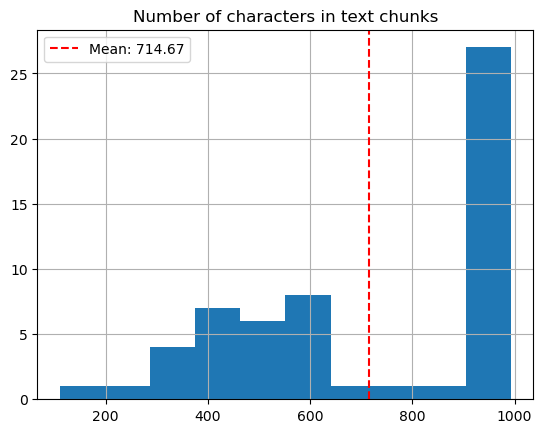

In [6]:
import matplotlib.pyplot as plt

chunk_lengths = [len(chunk.page_content) for chunk in texts]
len_df = pd.DataFrame({'chunk': range(len(texts)), 'N_characters': chunk_lengths})
mean_len = len_df['N_characters'].mean()

len_df['N_characters'].hist()
plt.axvline(x=mean_len, color='red', linestyle='--', label=f'Mean: {mean_len:.2f}')
plt.title('Number of characters in text chunks')
plt.legend();

In [7]:
from langchain_groq import ChatGroq
from langchain.llms import Ollama
llm = Ollama(model="llama3:8b")

In [8]:
gc.collect()

3524

In [9]:
prompt_to_generate_question = """
You are a helpful assistant that creates a question based on the passage you are given.

Read the passages below and create one question based on the most relevant information on the passage.

The question must be in the same language as the passage you are given.

Use only the following passage to create the question:

{passage}

Question:
"""


QUESTION_PROMPT = PromptTemplate(
#     template = prompt_to_generate_question,
    template =  '[INST]' + prompt_to_generate_question + '[/INST]',
    input_variables = ["passage"]
)

question_chain = LLMChain(prompt=QUESTION_PROMPT, llm=llm)
# question_chain.invoke("Who is auther of the book")

In [10]:
prompt_to_generate_answer = """
You are a helpful assistant that answers a given question based on a given passage.

The answer must be in the same language as the passage you are given.

Question: {question}

Use only the following passage to answer the question:

{passage}

Answer:
"""


ANSWER_PROMPT = PromptTemplate(
#     template = prompt_to_generate_answer,
    template = '[INST]' + prompt_to_generate_answer + '[/INST]',
    input_variables = ["question", "passage"]
)

answer_chain = LLMChain(prompt=ANSWER_PROMPT, llm=llm)

In [11]:
df = pd.DataFrame(columns=['Question', 'Answer', 'Book', 'Page', 'Seconds'])

for doc_number, doc in enumerate(texts):
    
    start_time = time.time()
    
    doc_text = doc.page_content
    print(f"doc_text for document {doc_text}")
    print(f"length of the document {len(doc_text)}")
    book = doc.metadata['source'].split('/')[-1]
    print(f"book for document {book}")
    page = doc.metadata['page']
    print(f"Page for the document {page}")
    
    if len(doc_text) >= CFG.MIN_CHUNK_SIZE and page >= CFG.PAGES_TO_SKIP:
        
        ### generate question
        generated_question = question_chain.invoke(
            {
                "passage": doc_text
            }
        )
        
        ### generate answer
        generated_answer = answer_chain.invoke(
            {
                "question": generated_question,
                "passage": doc_text
            }
        )
        
        end_time = time.time()
        elapsed_time = round(end_time - start_time, 2)
        
        ### store in df
        new_data_point = {
            'Question': generated_question['text'],
            'Answer': generated_answer['text'],
            'Book': book,
            'Page': page,
            'Seconds': elapsed_time
        }
    
        df = pd.concat([df, pd.DataFrame([new_data_point])], ignore_index=True)
        
        if doc_number >= CFG.MAX_CHUNKS:
            break
    
### persist synthetic data
df.to_csv("G:\\Sysnthetic_DataGen\\Output\\sysnthic.csv", index=False)

clear_output()

In [12]:
### total time
print(f"Seconds taken to generate Q/A pairs: {round( sum(df['Seconds']), 2 )}")
print(f"\nMinutes taken to generate Q/A pairs: {round( sum(df['Seconds'])/60, 2 )}")

Seconds taken to generate Q/A pairs: 9194.28

Minutes taken to generate Q/A pairs: 153.24


In [13]:
### average time
print(f"Average time (s) taken to generate Q/A pairs: {round( sum(df['Seconds'])/len(df), 2 )}")
print(f"\nAverage time (min) taken to generate Q/A pairs: {round( sum(df['Seconds'])/(60*len(df)), 2 )}")

Average time (s) taken to generate Q/A pairs: 195.62

Average time (min) taken to generate Q/A pairs: 3.26


In [14]:
df

,Question,Answer,Book,Page,Seconds
0,Here is the question based on the passage:\n\n...,क्या भारत सरकार ने देश के सभी लोगों और क्षेत्र...,G:\Sysnthetic_DataGen\budget_speech.pdf,5,252.14
1,"Based on the passage, here's a question:\n\nक्...",क्या सरकार के लिए आने वाली मंदत एक पुनर्नवाजित...,G:\Sysnthetic_DataGen\budget_speech.pdf,5,135.93
2,"Based on the passage, here's a question in Hin...","Based on the passage, here's an answer in Hind...",G:\Sysnthetic_DataGen\budget_speech.pdf,6,251.22
3,"Based on the passage, here's a question in Hin...",कि सरकार का मानना है कि सोशल जस्टिस एक प्रभावी...,G:\Sysnthetic_DataGen\budget_speech.pdf,6,188.76
4,"Based on the passage, here is a question that ...","क्या प्रधानमंत्री के अनुसार, देश की प्रगति के ...",G:\Sysnthetic_DataGen\budget_speech.pdf,7,224.97
5,"Based on the passage, here is one question I c...",क्या सरकार की 'सरकार का साथ' योजना के तहत 25 क...,G:\Sysnthetic_DataGen\budget_speech.pdf,7,169.76
6,"Based on the passage, here's a question:\n\nक्...","Based on the passage, here's a question:\n\nक्...",G:\Sysnthetic_DataGen\budget_speech.pdf,8,259.38
7,"Based on the passage, here's a question:\n\nक्...",क्रॉप इंश्योरेंस पी एम फसाल बीमा योजना के तहत ...,G:\Sysnthetic_DataGen\budget_speech.pdf,8,169.74
8,"Based on the passage, I create a question in H...","Based on the passage, I create a question in H...",G:\Sysnthetic_DataGen\budget_speech.pdf,9,224.78
9,Here's the question based on the passage:\n\nक...,क्या भारत में स्केलिंग न्यू हाइट्स की प्रगति क...,G:\Sysnthetic_DataGen\budget_speech.pdf,9,214.24


In [20]:
print(f'Raw synthetic dataset: {df.shape}')

### drop rows where 'passage' is mentioned
df = df[~df['Question'].str.contains('passage')].reset_index(drop=True)
df = df[~df['Answer'].str.contains('passage')].reset_index(drop=True)

print(f'No reference to "passage": {df.shape}')

### drop rows where the column Question is equal to the column Answer
df = df[df['Question'] != df['Answer']]

def replace_matching_substring(row):
    question = row['Question']
    answer = row['Answer']
    if question in answer:
        return answer.replace(question, '')
    else:
        return answer

df['Answer'] = df.apply(replace_matching_substring, axis=1)

### remove rows where 'Question' or 'Answer' is empty
df = df.dropna(subset=['Question', 'Answer'])

print(f'No parroting: {df.shape}')

### persist synthetic data
df.to_csv("G:\\Sysnthetic_DataGen\\Output\\synth_filtered.csv", index=False)

df

Raw synthetic dataset: (0, 5)
No reference to "passage": (0, 5)


ValueError: Columns must be same length as key

In [16]:
RED = '\033[91m'
BLUE = '\033[94m'
ORANGE = '\033[93m'
RESET = '\033[0m' # Reset color to default

for row in range(len(df)):
    print(f'{RED}\nSource: {df.Book[row]} - Page: {df.Page[row]}{RESET}')
    print(f'{BLUE}\n{df.Question[row]}{RESET}')
    print(f'{ORANGE}\n{df.Answer[row]}\n{RESET}')
    print('*'*80)
    
    if row >= 10:
        break

In [8]:
import pandas as pd
df = pd.read_csv("G:\\Sysnthetic_DataGen\\Output\\sysnthic.csv")
df.shape

(47, 5)

In [19]:
# df_output[["Question"]]

,Question
0,Here is the question based on the passage:\n\n...
1,"Based on the passage, here's a question:\n\nक्..."
2,"Based on the passage, here's a question in Hin..."
3,"Based on the passage, here's a question in Hin..."
4,"Based on the passage, here is a question that ..."
5,"Based on the passage, here is one question I c..."
6,"Based on the passage, here's a question:\n\nक्..."
7,"Based on the passage, here's a question:\n\nक्..."
8,"Based on the passage, I create a question in H..."
9,Here's the question based on the passage:\n\nक...


In [5]:
print(f'Raw synthetic dataset: {df.shape}')

# Drop rows where 'passage' is mentioned
df = df[~df['Question'].str.contains('passage', na=False)].reset_index(drop=True)
df = df[~df['Answer'].str.contains('passage', na=False)].reset_index(drop=True)

print(f'No reference to "passage": {df.shape}')

# Drop rows where the column Question is equal to the column Answer
df = df[df['Question'] != df['Answer']]
print(f" Records where question and answer are not same {df.shape}")

# Replace matching substrings function
def replace_matching_substring(row):
    question = row['Question']
    answer = row['Answer']
    if isinstance(question, str) and isinstance(answer, str):
        if question in answer:
            return answer.replace(question, '')
        else:
            return answer
    return answer  # Return original answer if data is not valid

# Ensure all replacements are consistent
df['Answer'] = df.apply(replace_matching_substring, axis=1)

# Remove rows where 'Question' or 'Answer' is empty
df = df.dropna(subset=['Question', 'Answer'])

print(f'No parroting: {df.shape}')

# Persist the filtered synthetic data
df.to_csv("G:\\Sysnthetic_DataGen\\Output\\synth_filtered.csv", index=False)

df


Raw synthetic dataset: (47, 5)
No reference to "passage": (0, 5)
 Records where question and answer are not same (0, 5)
No parroting: (0, 5)


,Question,Answer,Book,Page,Seconds


In [7]:
# Print the first 10 rows before any filtering for debugging
print("Initial dataset preview:")
print(df.head(10))

print(f'Raw synthetic dataset: {df.shape}')

# Drop rows where 'passage' is mentioned
df = df[~df['Question'].str.contains('passage', case=False, na=False)]
df = df[~df['Answer'].str.contains('passage', case=False, na=False)]

print(f'No reference to "passage": {df.shape}')
print("After removing rows with 'passage':")
print(df.head(10))  # Print first 10 rows after filtering for debugging

# Drop rows where the column Question is equal to the column Answer
df = df[df['Question'] != df['Answer']]

print(f"Records where question and answer are not same: {df.shape}")
print("After removing rows where Question and Answer are the same:")
print(df.head(10))  # Print first 10 rows after filtering for debugging

# Replace matching substrings function
def replace_matching_substring(row):
    question = row['Question']
    answer = row['Answer']
    if isinstance(question, str) and isinstance(answer, str):
        if question in answer:
            return answer.replace(question, '')
        else:
            return answer
    return answer

# Apply the function and check the column shape
df['Answer'] = df.apply(replace_matching_substring, axis=1)
print("After applying substring replacement:")
print(df.head(10))

# Remove rows where 'Question' or 'Answer' is empty
df = df.dropna(subset=['Question', 'Answer'])

print(f'No parroting: {df.shape}')
print("Final filtered dataset preview:")
print(df.head(10))

# Persist the filtered synthetic data
df.to_csv("G:\\Sysnthetic_DataGen\\Output\\synth_filtered.csv", index=False)

df


Initial dataset preview:
                                            Question  \
0  Here is the question based on the passage:\n\n...   
1  Based on the passage, here's a question:\n\nक्...   
2  Based on the passage, here's a question in Hin...   
3  Based on the passage, here's a question in Hin...   
4  Based on the passage, here is a question that ...   
5  Based on the passage, here is one question I c...   
6  Based on the passage, here's a question:\n\nक्...   
7  Based on the passage, here's a question:\n\nक्...   
8  Based on the passage, I create a question in H...   
9  Here's the question based on the passage:\n\nक...   

                                              Answer  \
0  क्या भारत सरकार ने देश के सभी लोगों और क्षेत्र...   
1  क्या सरकार के लिए आने वाली मंदत एक पुनर्नवाजित...   
2  Based on the passage, here's an answer in Hind...   
3  कि सरकार का मानना है कि सोशल जस्टिस एक प्रभावी...   
4  क्या प्रधानमंत्री के अनुसार, देश की प्रगति के ...   
5  क्या सरकार की 'सरका

,Question,Answer,Book,Page,Seconds


In [10]:
# Set max_colwidth to None to display the full contents of each column without truncation
pd.set_option('display.max_colwidth', None)

# If you also want to see all columns without truncation, set max_columns to None
pd.set_option('display.max_columns', None)

# If you're working with large datasets and want to see more rows, adjust max_rows
pd.set_option('display.max_rows', None)

In [11]:
# Print initial dataset for debugging purposes
print("Initial dataset preview:")
print(df.head(10))

print(f'Raw synthetic dataset: {df.shape}')

# Replace occurrences of "passage" with an empty string in both Question and Answer columns
df['Question'] = df['Question'].str.replace('passage', '', case=False, regex=True)
df['Answer'] = df['Answer'].str.replace('passage', '', case=False, regex=True)

print(f"No reference to 'passage': {df.shape}")
print("After replacing 'passage' string in Questions and Answers:")
print(df.head(10))

# Drop rows where the column Question is equal to the column Answer
df = df[df['Question'] != df['Answer']]

print(f"Records where Question and Answer are not the same: {df.shape}")
print("After removing rows where Question and Answer are the same:")
print(df.head(10))

# Replace matching substrings function
def replace_matching_substring(row):
    question = row['Question']
    answer = row['Answer']
    if isinstance(question, str) and isinstance(answer, str):
        if question in answer:
            return answer.replace(question, '')
        else:
            return answer
    return answer

# Apply the function and ensure consistent output
df['Answer'] = df.apply(replace_matching_substring, axis=1)

print("After applying substring replacement:")
print(df.head(10))

# Remove rows where 'Question' or 'Answer' is empty
df = df.dropna(subset=['Question', 'Answer'])

print(f'No parroting: {df.shape}')
print("Final filtered dataset preview:")
print(df.head(10))

# Persist the filtered synthetic data
df.to_csv("G:\\Sysnthetic_DataGen\\Output\\synth_filtered.csv", index=False)

df


Initial dataset preview:
                                                                                                                                                                                                                                                                                                                                                                                                  Question  \
0                                                               Here is the question based on the :\n\nक्या भारत सरकार ने देश के सभी लोगों और क्षेत्रों के समग्र विकास के लिए अपने अध्यक्ष के नेतृत्व में दोगुना प्रयास किया?\n\n(What did the Indian Government do to double down on its efforts for comprehensive development of all people and all regions under the leadership of the Prime Minister?)   
1                                                                                                                                                                                  

,Question,Answer,Book,Page,Seconds
0,Here is the question based on the :\n\nक्या भारत सरकार ने देश के सभी लोगों और क्षेत्रों के समग्र विकास के लिए अपने अध्यक्ष के नेतृत्व में दोगुना प्रयास किया?\n\n(What did the Indian Government do to double down on its efforts for comprehensive development of all people and all regions under the leadership of the Prime Minister?),क्या भारत सरकार ने देश के सभी लोगों और क्षेत्रों के समग्र विकास के लिए अपने अध्यक्ष के नेतृत्व में दोगुना प्रयास किया?\n\nTranslation: What did the Indian Government do to double down on its efforts for comprehensive development of all people and all regions under the leadership of the Prime Minister?,G:\Sysnthetic_DataGen\budget_speech.pdf,5,252.14
1,"Based on the , here's a question:\n\nक्या सरकार के लिए आने वाली मандत एक पुनर्नवाजित आश्चर्य होगी?\n\nTranslation: Will the coming mandate for the government be another resounding success?",क्या सरकार के लिए आने वाली मंदत एक पुनर्नवाजित आश्चर्य होगी?\n\nTranslation: Will the coming mandate for the government be another resounding success?,G:\Sysnthetic_DataGen\budget_speech.pdf,5,135.93
2,"Based on the , here's a question in Hindi:\n\nक्या सरकार की सर्वांगीण, सर्वस्पर्षी और सर्वसमवर्शी सम्भाव नीति के माध्यम से 2047 तक भारत एक 'विक्सित भारत' बनाने की मंशा है? (What is the government's aim to make India a 'Viksit Bharat' by 2047 through its all-round, all-pervasive and all-inclusive development policy?)","Based on the , here's an answer in Hindi:\n\nसरका की सर्वांगी, सर्वस्पर्षी और सर्वसमवर्षी सम्भाव नीति के माध्यम से 2047 तक भारत एक 'विक्सित भारत' बनाने की मंशा है - लोगों की क्षमता को सुधारने और उन्हें शक्ति देने के लिए। (What is the government's aim to make India a 'Viksit Bharat' by 2047 through its all-round, all-pervasive and all-inclusive development policy? - It is to improve people's capability and empower them.)",G:\Sysnthetic_DataGen\budget_speech.pdf,6,251.22
3,"Based on the , here's a question in Hindi:\n\nकिससे संबंधित है सरकार का मानना है कि सоциल जस्टिस एक प्रभावी और आवश्यक शासन मॉडल है? (Kisase sambandhit hai sarakār kā mānana hai ki sociol jasutisa ek prabhaavit aur avashyakt shasan mōdala hai?)\n\nTranslation: Who is related to the government's view that social justice is an effective and necessary governance model?",कि सरकार का मानना है कि सोशल जस्टिस एक प्रभावी और आवश्यक शासन मॉडल है। (Ki sarakār kā mānana hai ki sociol jasutisa ek prabhaavit aur avashyakt shasan mōdala hai?)\n\nTranslation: Who is related to the government's view that social justice is an effective and necessary governance model?,G:\Sysnthetic_DataGen\budget_speech.pdf,6,188.76
4,"Based on the , here is a question that can be created:\n\nक्या प्रधानमंत्री के अनुसार, देश की प्रगति के लिए सबसे उच्च पRIORITY वाले चार मुख्य वर्ग हैं - गरीब, महिलाएं, युवा और अन्नADATA?\n\nTranslation: What are the four major categories that the Prime Minister believes should have highest priority for the country's progress?","क्या प्रधानमंत्री के अनुसार, देश की प्रगति के लिए सबसे उच्च पRIORITY वाले चार मुख्य वर्ग हैं - गरीब, महिलाएं, युवा और अन्नadata?",G:\Sysnthetic_DataGen\budget_speech.pdf,7,224.97
5,"Based on the , here is one question I came up with:\n\nक्या सरकार की 'सरकार का साथ' योजना के तहत 10 वर्षों में 25 करोड़ लोगों ने स्थिति से मुक्त हुए?\n\nTranslation: Did the government's ""Sabka Ka Saath"" program, under which 25 crore people got freedom from poverty in 10 years?","क्या सरकार की 'सरकार का साथ' योजना के तहत 25 करोड़ लोगों ने स्ثिति से मुक्त हुए? (Yes, under the government's ""Sabka Ka Saath"" program, the Government has assisted 25 crore people to get freedom from poverty.)",G:\Sysnthetic_DataGen\budget_speech.pdf,7,169.76
6,"Based on the , here's a question:\n\nक्या प्रधानमंत्री किसान सम्मान योजना के तहत सीधा वित्तीय सहायता 11.8 करोड़ किसानों को प्रदान की जाती है?\n\n(Translation: What is the number of farmers who receive direct financial assistance under PM-KISAN SAMMAN Yojana?)\n\nThis question is relevant to the as it specifically men

In [12]:
df[["Question"]]

,Question
0,Here is the question based on the :\n\nक्या भारत सरकार ने देश के सभी लोगों और क्षेत्रों के समग्र विकास के लिए अपने अध्यक्ष के नेतृत्व में दोगुना प्रयास किया?\n\n(What did the Indian Government do to double down on its efforts for comprehensive development of all people and all regions under the leadership of the Prime Minister?)
1,"Based on the , here's a question:\n\nक्या सरकार के लिए आने वाली मандत एक पुनर्नवाजित आश्चर्य होगी?\n\nTranslation: Will the coming mandate for the government be another resounding success?"
2,"Based on the , here's a question in Hindi:\n\nक्या सरकार की सर्वांगीण, सर्वस्पर्षी और सर्वसमवर्शी सम्भाव नीति के माध्यम से 2047 तक भारत एक 'विक्सित भारत' बनाने की मंशा है? (What is the government's aim to make India a 'Viksit Bharat' by 2047 through its all-round, all-pervasive and all-inclusive development policy?)"
3,"Based on the , here's a question in Hindi:\n\nकिससे संबंधित है सरकार का मानना है कि सоциल जस्टिस एक प्रभावी और आवश्यक शासन मॉडल है? (Kisase sambandhit hai sarakār kā mānana hai ki sociol jasutisa ek prabhaavit aur avashyakt shasan mōdala hai?)\n\nTranslation: Who is related to the government's view that social justice is an effective and necessary governance model?"
4,"Based on the , here is a question that can be created:\n\nक्या प्रधानमंत्री के अनुसार, देश की प्रगति के लिए सबसे उच्च पRIORITY वाले चार मुख्य वर्ग हैं - गरीब, महिलाएं, युवा और अन्नADATA?\n\nTranslation: What are the four major categories that the Prime Minister believes should have highest priority for the country's progress?"
5,"Based on the , here is one question I came up with:\n\nक्या सरकार की 'सरकार का साथ' योजना के तहत 10 वर्षों में 25 करोड़ लोगों ने स्थिति से मुक्त हुए?\n\nTranslation: Did the government's ""Sabka Ka Saath"" program, under which 25 crore people got freedom from poverty in 10 years?"
6,"Based on the , here's a question:\n\nक्या प्रधानमंत्री किसान सम्मान योजना के तहत सीधा वित्तीय सहायता 11.8 करोड़ किसानों को प्रदान की जाती है?\n\n(Translation: What is the number of farmers who receive direct financial assistance under PM-KISAN SAMMAN Yojana?)\n\nThis question is relevant to the as it specifically mentions the PM-KISAN scheme and the number of farmers who benefit from it."
7,"Based on the , here's a question:\n\nक्या पीएम फसाल बीमा योजना के तहत 4 करोड़ किसानों को क्रॉप इंश्योरेंस दी जाती है? (What are the 4 crore farmers given crop insurance under PM Fasal Bima Yojana?)\n\nThis question is relevant to the most important information in the , which mentions PM Fasal Bima Yojana and the number of farmers receiving crop insurance."
8,"Based on the , I create a question in Hindi:\n\nकिसके लिए सामर्थ्य काफी होना चाहिए और युवाओं को सक्षम बनाना है?\n\n(Translation: For whose prosperity is it necessary to equip and empower youth?)\n\nThis question is based on the 's emphasis on empowering the youth for India's prosperity, as mentioned in point 17."
9,"Here's the question based on the :\n\nक्या भारत में स्केलिंग न्यू हाइट्स की प्रगति के लिए युवाओं की संख्या 2023 में एशियन गेम्स और पैरागेम्स में उच्चतम पदक संख्या के साथ वृद्ध हुई है? (What is the number of youth who are scaling new heights in India, which saw a high medal tally along with over 80 chess grandmasters in 2023?)"


In [13]:
df[["Answer"]]

,Answer
0,क्या भारत सरकार ने देश के सभी लोगों और क्षेत्रों के समग्र विकास के लिए अपने अध्यक्ष के नेतृत्व में दोगुना प्रयास किया?\n\nTranslation: What did the Indian Government do to double down on its efforts for comprehensive development of all people and all regions under the leadership of the Prime Minister?
1,क्या सरकार के लिए आने वाली मंदत एक पुनर्नवाजित आश्चर्य होगी?\n\nTranslation: Will the coming mandate for the government be another resounding success?
2,"Based on the , here's an answer in Hindi:\n\nसरका की सर्वांगी, सर्वस्पर्षी और सर्वसमवर्षी सम्भाव नीति के माध्यम से 2047 तक भारत एक 'विक्सित भारत' बनाने की मंशा है - लोगों की क्षमता को सुधारने और उन्हें शक्ति देने के लिए। (What is the government's aim to make India a 'Viksit Bharat' by 2047 through its all-round, all-pervasive and all-inclusive development policy? - It is to improve people's capability and empower them.)"
3,कि सरकार का मानना है कि सोशल जस्टिस एक प्रभावी और आवश्यक शासन मॉडल है। (Ki sarakār kā mānana hai ki sociol jasutisa ek prabhaavit aur avashyakt shasan mōdala hai?)\n\nTranslation: Who is related to the government's view that social justice is an effective and necessary governance model?
4,"क्या प्रधानमंत्री के अनुसार, देश की प्रगति के लिए सबसे उच्च पRIORITY वाले चार मुख्य वर्ग हैं - गरीब, महिलाएं, युवा और अन्नadata?"
5,"क्या सरकार की 'सरकार का साथ' योजना के तहत 25 करोड़ लोगों ने स्ثिति से मुक्त हुए? (Yes, under the government's ""Sabka Ka Saath"" program, the Government has assisted 25 crore people to get freedom from poverty.)"
6,"Based on the , here's a question:\n\nक्या प्रधानमंतْرी किसान सम्मान योजना के तहत सीघ वि‍त्ती‍य सहा‍यता 11.8 करोड़ कि‍सा‍नों को प्र‍दा‍न की जा‍ती है?\n\n(Translation: What is the number of farmers who receive direct financial assistance under PM-KISAN SAMMAN Yojana?)\n\nAnswer:\n\n11.8 करोड़ किसानों को प्र‍दा‍न की जाती है। (Translation: 11.8 crore farmers receive direct financial assistance.)"
7,क्रॉप इंश्योरेंस पी एम फसाल बीमा योजना के तहत ४ करोड़ कि‍सानों को दी जाती है. (Crop insurance is given to 4 crore farmers under PM Fasal Bima Yojana.)
8,"Based on the , I create a question in Hindi:\n\nकिसे लिए समृद्धि का फ़ीह होना चाहिए और युवाओं को सक्षम बनाना है?\n\n(Translation: For whose prosperity is it necessary to equip and empower youth?)\n\nAnswer:\nयुवाओं के लिए (For the youth)"
9,"क्या भारत में स्केलिंग न्यू हाइट्स की प्रगति के लिए युवाओं की संख्या 2023 में एशियन गेम्स और पैरागेम्स में उच्चतम पदक संख्या के साथ वृद्ध हुई है? (What is the number of youth who are scaling new heights in India, which saw a high medal tally along with over 80 chess grandmasters in 2023?)\n\nAnswer: युवाओं की संख्या (The number of youth) - This information is not provided in the given . The only talks about the country being proud of its youth scaling new heights in sports and mentions that India has over 80 chess grandmasters compared to little over 20 in 2010, but it does not provide a specific number for ""youth who are scaling new heights""."
